In [1]:
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import os

# Helper function for RMSLE calculation
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))

# Load your dataset
data = pd.read_csv('/content/final_training_file.csv')

# Directory to save models and scalers
model_dir = 'statewise_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Create an empty dictionary to store evaluation metrics
evaluation_metrics = {}

# List of unique states in the data
unique_states = data['State'].unique()

# Loop through each state and train a model for each
for state in unique_states:
    print(f"Training model for {state}...")

    # Filter data for the current state
    state_data = data[data['State'] == state].copy()

    # Drop rows with NaN values
    state_data.dropna(inplace=True)

    # Check if there are enough data points to train the model
    if state_data.shape[0] < 10:  # If there are less than 10 rows, skip this state
        print(f"Skipping {state} due to insufficient data.")
        continue

    # Step 2: Log-transform the target variable
    target = np.log1p(state_data['electric_vehicles_sold'])

    # Step 3: Feature selection (Excluding lagged features and rolling averages)
    features = state_data[['total_vehicles_sold', 'Population', 'EV_Stations',
                           'Petroleum_Consumption', 'Monthly Inflation Rate', 'State-wise GDP']]

    # Step 4: Data Scaling
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Step 5: Train-test split
    X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.2, random_state=42)

    # Step 6: Train Initial Random Forest model
    rf_model = RandomForestRegressor(n_estimators=300, max_depth=10, max_features='sqrt', random_state=42)
    rf_model.fit(X_train, y_train)

    # Step 7: Make predictions
    y_pred_log = rf_model.predict(X_test)
    y_pred = np.expm1(y_pred_log)  # Convert predictions back from log scale
    y_pred_clipped = np.clip(y_pred, 0, None)

    # Step 8: Evaluate MAPE and RMSLE
    mape_clipped = mean_absolute_percentage_error(np.expm1(y_test), y_pred_clipped)  # Convert test values back
    rmsle_clipped = rmsle(np.expm1(y_test), y_pred_clipped)

    print(f'MAPE after Random Forest for {state}: {mape_clipped * 100:.2f}%')
    print(f'RMSLE after Random Forest for {state}: {rmsle_clipped:.2f}')

    # Save the evaluation metrics
    evaluation_metrics[state] = {'MAPE': mape_clipped * 100, 'RMSLE': rmsle_clipped}

    # Save the model and scaler for the state
    joblib.dump(rf_model, f'{model_dir}/{state}_rf_model.pkl')
    joblib.dump(scaler, f'{model_dir}/{state}_scaler.pkl')

    # Optional: Hyperparameter Tuning
    param_grid_rf = {
        'n_estimators': [200, 300, 400, 500],
        'max_depth': [6, 8, 10, 12],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=3, scoring='neg_mean_squared_error', verbose=1)
    grid_search_rf.fit(X_train, y_train)
    best_params_rf = grid_search_rf.best_params_
    print(f"Best Hyperparameters for {state}: {best_params_rf}")

    # Re-train the model with the best hyperparameters
    rf_model_tuned = RandomForestRegressor(**best_params_rf, random_state=42)
    rf_model_tuned.fit(X_train, y_train)

    # Save the tuned model for the state
    joblib.dump(rf_model_tuned, f'{model_dir}/{state}_rf_model_tuned.pkl')

    # Step 10: Evaluate after hyperparameter tuning
    y_pred_tuned_log = rf_model_tuned.predict(X_test)
    y_pred_tuned = np.expm1(y_pred_tuned_log)  # Convert predictions back from log scale
    y_pred_clipped_tuned = np.clip(y_pred_tuned, 0, None)
    mape_tuned = mean_absolute_percentage_error(np.expm1(y_test), y_pred_clipped_tuned)
    rmsle_tuned = rmsle(np.expm1(y_test), y_pred_clipped_tuned)

    print(f'MAPE after tuning for {state}: {mape_tuned * 100:.2f}%')
    print(f'RMSLE after tuning for {state}: {rmsle_tuned:.2f}')

    # Save the tuned evaluation metrics
    evaluation_metrics[state]['Tuned_MAPE'] = mape_tuned * 100
    evaluation_metrics[state]['Tuned_RMSLE'] = rmsle_tuned

# Display final evaluation metrics for all states
for state, metrics in evaluation_metrics.items():
    print(f"\nMetrics for {state}: {metrics}")

# Optional: Save evaluation metrics to a file
evaluation_df = pd.DataFrame.from_dict(evaluation_metrics, orient='index')
evaluation_df.to_csv('statewise_model_evaluation_metrics.csv', index=True)


Training model for andaman & nicobar islands...
MAPE after Random Forest for andaman & nicobar islands: 94801780934082944.00%
RMSLE after Random Forest for andaman & nicobar islands: 0.66
Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best Hyperparameters for andaman & nicobar islands: {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
MAPE after tuning for andaman & nicobar islands: 66474665472553960.00%
RMSLE after tuning for andaman & nicobar islands: 0.73
Training model for andhra pradesh...
MAPE after Random Forest for andhra pradesh: 32.54%
RMSLE after Random Forest for andhra pradesh: 0.50
Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best Hyperparameters for andhra pradesh: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
MAPE after tuning for andhra pradesh: 34.20%
RMSLE after tuning for andhra pradesh: 0.50
Training model for arunachal pradesh...
MAPE after Random Forest f

In [3]:
import joblib
import pandas as pd
import numpy as np
import os

# Directory where state-specific models and scalers are saved
model_dir = 'statewise_models'

# Load the prediction dataset (ensure it contains data from Jan 2025 to Dec 2026)
prediction_data_path = '/content/prediction_final.csv'  # Adjust to your file path
prediction_data = pd.read_csv(prediction_data_path)

# Rename columns to match the features used during training (if necessary)
prediction_data.rename(columns={'Predicted_Petroleum_Sales': 'Petroleum_Consumption'}, inplace=True)
prediction_data.rename(columns={'Predicted_EV_Stations': 'EV_Stations'}, inplace=True)

# Define the features used during training, including the dummy lagged features
trained_feature_names = ['total_vehicles_sold', 'Population', 'EV_Stations',
                         'Petroleum_Consumption', 'Monthly Inflation Rate', 'State-wise GDP']

# Get the unique states in the prediction data
unique_states = prediction_data['State'].unique()

# Empty list to store predictions for each state
all_predictions = []

# Loop through each state and make predictions using the corresponding model
for state in unique_states:
    print(f"Making predictions for {state}...")

    # Load the saved model and scaler for the state
    model_filename = os.path.join(model_dir, f'{state}_rf_model_tuned.pkl')
    scaler_filename = os.path.join(model_dir, f'{state}_scaler.pkl')

    if os.path.exists(model_filename) and os.path.exists(scaler_filename):
        rf_model = joblib.load(model_filename)
        scaler = joblib.load(scaler_filename)
    else:
        print(f"Warning: Model or scaler not found for {state}. Skipping...")
        continue

    # Filter the data for the current state
    state_prediction_data = prediction_data[prediction_data['State'] == state].copy()

    # Reorder the prediction features to match the feature names used during training
    prediction_features = state_prediction_data[trained_feature_names]

    # Scale the prediction features using the saved scaler
    scaled_prediction_features = scaler.transform(prediction_features)

    # Make predictions using the loaded model
    predicted_ev_sales_log = rf_model.predict(scaled_prediction_features)

    # Convert predictions back from the log scale using np.expm1()
    predicted_ev_sales = np.expm1(predicted_ev_sales_log)

    # Clip negative values in the predictions
    predicted_ev_sales_clipped = np.clip(predicted_ev_sales, 0, None)

    # Add the predictions to the state's prediction data
    state_prediction_data['Predicted_EV_Sales'] = predicted_ev_sales_clipped

    # Append the state's predictions to the list
    all_predictions.append(state_prediction_data)

# Concatenate all state predictions into a single DataFrame
final_predictions_df = pd.concat(all_predictions, ignore_index=True)

# Display the first few rows of the final predictions
print(final_predictions_df[['State', 'Date', 'Predicted_EV_Sales']].head())

# Optionally, save the results to a CSV file
final_predictions_df.to_csv('/content/predicted_ev_sales_2025_2026_all_states.csv', index=False)
print('Predictions saved to predicted_ev_sales_2025_2026_all_states.csv')


Making predictions for andaman & nicobar islands...
Making predictions for andhra pradesh...
Making predictions for arunachal pradesh...
Making predictions for assam...
Making predictions for bihar...
Making predictions for chandigarh...
Making predictions for chhattisgarh...
Making predictions for delhi...
Making predictions for dnh and dd...
Making predictions for goa...
Making predictions for gujarat...
Making predictions for haryana...
Making predictions for himachal pradesh...
Making predictions for jammu & kashmir...
Making predictions for jharkhand...
Making predictions for karnataka...
Making predictions for kerala...
Making predictions for lakshadweep...
Making predictions for madhya pradesh...
Making predictions for maharashtra...
Making predictions for manipur...
Making predictions for meghalaya...
Making predictions for mizoram...
Making predictions for nagaland...
Making predictions for odisha...
Making predictions for puducherry...
Making predictions for punjab...
Making 

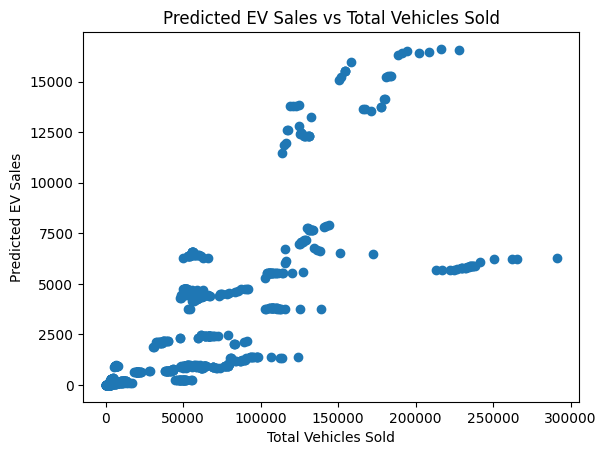

In [13]:
import matplotlib.pyplot as plt

# Plot predicted values vs some reference (e.g., total vehicles sold)
plt.scatter(final_predictions_df['total_vehicles_sold'], final_predictions_df['Predicted_EV_Sales'])
plt.xlabel('Total Vehicles Sold')
plt.ylabel('Predicted EV Sales')
plt.title('Predicted EV Sales vs Total Vehicles Sold')
plt.show()


In [4]:
# Check distribution of total vehicles sold in training vs prediction data
print("Training Data Distribution:")
print(data['total_vehicles_sold'].describe())

print("\nPrediction Data Distribution:")
print(prediction_data['total_vehicles_sold'].describe())


Training Data Distribution:
count      1223.000000
mean      46786.796402
std       57543.461948
min           2.000000
25%        2814.500000
50%       30519.000000
75%       70407.000000
max      430675.000000
Name: total_vehicles_sold, dtype: float64

Prediction Data Distribution:
count       816.000000
mean      52537.791040
std       56810.668751
min           9.826454
25%        3324.948511
50%       47680.173067
75%       80513.677684
max      290998.979368
Name: total_vehicles_sold, dtype: float64


In [9]:
important_features = ['total_vehicles_sold', 'Population', 'EV_Stations', 'Petroleum_Consumption', 'State-wise GDP']
for feature in important_features:
    print(f"\nTraining Data Distribution of {feature}:")
    print(data[feature].describe())

    print(f"\nPrediction Data Distribution of {feature}:")
    print(prediction_data[feature].describe())



Training Data Distribution of total_vehicles_sold:
count      1223.000000
mean      46786.796402
std       57543.461948
min           2.000000
25%        2814.500000
50%       30519.000000
75%       70407.000000
max      430675.000000
Name: total_vehicles_sold, dtype: float64

Prediction Data Distribution of total_vehicles_sold:
count       816.000000
mean      52537.791040
std       56810.668751
min           9.826454
25%        3324.948511
50%       47680.173067
75%       80513.677684
max      290998.979368
Name: total_vehicles_sold, dtype: float64

Training Data Distribution of Population:
count    1.223000e+03
mean     3.640844e+06
std      4.276722e+06
min      3.686196e+04
25%      1.934020e+05
50%      2.488365e+06
75%      5.982025e+06
max      1.979114e+07
Name: Population, dtype: float64

Prediction Data Distribution of Population:
count    8.160000e+02
mean     3.580684e+06
std      4.431004e+06
min      6.389398e+03
25%      1.468067e+05
50%      2.115382e+06
75%      6.13

In [10]:
# Check the range of predicted EV sales
print("Training \n", data['electric_vehicles_sold'].describe())
print("prediciton\n", final_predictions_df['Predicted_EV_Sales'].describe())


Training 
 count     1223.000000
mean      1689.379395
std       3124.209603
min          0.000000
25%          9.000000
50%        321.000000
75%       1929.000000
max      27747.000000
Name: electric_vehicles_sold, dtype: float64
prediciton
 count      792.000000
mean      2513.667106
std       3653.717812
min          0.000000
25%         32.682488
50%        873.605206
75%       4344.540496
max      16615.755893
Name: Predicted_EV_Sales, dtype: float64
